In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
info_books = pd.read_csv('good_books_10k/good_books_en.csv')

In [3]:
info_books = info_books[info_books['description'].map(lambda x: len(x.split(' ')) > 10)]

In [4]:
info_books = info_books[~info_books['original_title'].isnull()]

In [5]:
info_books.shape

(6229, 13)

In [6]:
from gensim.models.fasttext import FastText
model = FastText(min_count = 1)
model.build_vocab(sentences = list(info_books['description']))
model.train(sentences = list(info_books['description']), total_examples = len(list(info_books['description'])), epochs = 10, alpha = 0.01)

In [7]:
import numpy as np
def get_vector(text):
  vector = np.array([model.wv[word] for word in text]).mean(axis = 0)
  return vector

In [8]:
info_books['vector_description'] = info_books['description'].apply(get_vector)

In [9]:
info_books.reset_index(drop = True, inplace = True)

In [10]:
X = list(info_books['vector_description'])
X = np.array(X)
X.shape

(6229, 100)

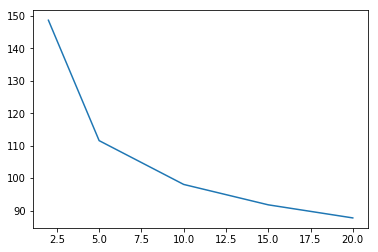

In [11]:
from sklearn.cluster import KMeans
n_clusters = [2, 5, 10, 15, 20]
inertia = []
for n in n_clusters:
  book_kmeans = KMeans(n_clusters = n)
  book_kmeans.fit(X)
  inertia.append(book_kmeans.inertia_)

plt.plot(n_clusters, inertia)

In [12]:
book_kmeans = KMeans(n_clusters = 10, random_state = 10).fit(X)
book_kmeans.labels_

array([7, 7, 7, ..., 7, 7, 8], dtype=int32)

In [13]:
len(book_kmeans.labels_)

6229

In [14]:
info_books['cluster'] = pd.Series(book_kmeans.labels_)

In [15]:
info_books.to_csv('good_books_10k/good_books_clustered.csv', index = False)

In [16]:
info_books[info_books['cluster'] == 7]

,goodreads_book_id,authors,original_publication_year,original_title,average_rating,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,description,check_alphabet,check_alternate,vector_description,cluster
0,2767052,Suzanne Collins,2008.0,The Hunger Games,4.34,66715,127936,560092,1481305,2706317,"['In', 'ruins', 'place', 'known', 'North', 'Am...",True,False,"[0.11182822, 0.27554494, 0.10497372, -0.244969...",7
1,3,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,4.44,75504,101676,455024,1156318,3011543,"['After', 'lifetime', 'bottling', 'magical', '...",True,False,"[0.11533161, 0.27479458, 0.10952906, -0.196303...",7
2,2657,Harper Lee,1960.0,To Kill a Mockingbird,4.25,60427,117415,446835,1001952,1714267,"['Compassionate', 'dramatic', 'deeply', 'movin...",True,False,"[0.12380465, 0.25847182, 0.092270814, -0.23617...",7
9,2429135,"Stieg Larsson, Reg Keeland",2005.0,Män som hatar kvinnor,4.11,54835,86051,285413,667485,836050,"['An', 'international', 'publishing', 'sensati...",True,False,"[0.11200584, 0.26793224, 0.10006423, -0.238042...",7
13,6,"J.K. Rowling, Mary GrandPré",2000.0,Harry Potter and the Goblet of Fire,4.53,6676,20210,151785,494926,1195045,"['Harry', 'Potter', 'midway', 'training', 'wiz...",True,False,"[0.10977235, 0.28257278, 0.117940165, -0.22215...",7
15,1,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,4.54,7308,21516,136333,459028,1161491,"['Harry', 'Ron', 'Hermione', 'passed', 'OWL', ...",True,False,"[0.094090894, 0.27298796, 0.10532154, -0.22159...",7
28,1934,Louisa May Alcott,1868.0,Little Women,4.04,31645,70011,250794,426280,535563,"['Generations', 'readers', 'young', 'old', 'ma...",True,False,"[0.0966611, 0.25715175, 0.09910447, -0.2340224...",7
33,4381,Ray Bradbury,1953.0,Fahrenheit 451,3.97,28366,64289,238242,426292,419051,"['Fahrenheit', '451', 'ofrece', 'la', 'histori...",True,False,"[0.110675484, 0.27615425, 0.088176765, -0.2644...",7
45,10917,Jodi Picoult,2004.0,My Sister's Keeper,4.06,17547,42763,162573,314003,350994,"['A', 'provocative', 'novel', 'raises', 'impor...",True,False,"[0.123865746, 0.25761893, 0.09441406, -0.25314...",7
54,157993,"Antoine de Saint-Exupéry, Richard Howard, Dom ...",1946.0,Le Petit Prince,4.28,15039,32866,114714,228440,468227,"['Moral', 'allegory', 'spiritual', 'autobiogra...",True,False,"[0.12672056, 0.24519618, 0.09255289, -0.243768...",7


In [20]:
def get_cosine_similarity(one, two):
    return np.dot(one, two)/(np.linalg.norm(one) * np.linalg.norm(two))

In [21]:
a = np.array([1, 2, 3])
b = np.array([0, 1, 1])
get_cosine_similarity(a, b)

0.944911182523068

In [161]:
import nltk
from nltk.tokenize import word_tokenize

In [155]:
# function to remove the 'Alternate Cover Edition ...' paragraph at the beginning 
def clean_cover_isbn(text):
  try:
    text = text.split('<br />')[2]
    return text
  except:
    return text

# function to remove html markings
from bs4 import BeautifulSoup
def clean_html(text):
  try:
    soup = BeautifulSoup(text, 'lxml')
    clean_text = soup.get_text()
    return clean_text
  except:
    return text

# function to remove punctuation
import string
def clean_punctuations(text):
  clean_text = "".join([c for c in text if c not in string.punctuation])
  return clean_text

def get_tokens(text):
    return word_tokenize(text)

In [156]:
from goodreads import client
goodreads_key = 't6mIkabukH29jAey0381yA'
goodreads_secret = '6IWvvO5CNFIAqUragee2Bb5HkEOvxIYqSXeXdFSHvM'
good_client = client.GoodreadsClient(goodreads_key, goodreads_secret)

In [157]:
test_book = good_client.book('77156')

In [159]:
test_book_description = test_book.description

In [167]:
test_book_vector = clean_cover_isbn(test_book_description)
test_book_vector = clean_html(test_book_vector)
test_book_vector = clean_punctuations(test_book_vector)
test_book_vector = get_tokens(test_book_vector)
test_book_vector = get_vector(test_book_vector)

In [168]:
test_book_vector = np.reshape(test_book_vector, (1, 100))

In [173]:
cluster_number = book_kmeans.predict(test_book_vector).item()

In [177]:
predicted_cluster = info_books[info_books['cluster'] == cluster_number]

In [178]:
predicted_cluster

,goodreads_book_id,authors,original_publication_year,original_title,average_rating,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,description,check_alphabet,check_alternate,vector_description,cluster
687,8698,Douglas Adams,1984.0,"So Long, and Thanks for All the Fish",4.08,624,4454,22611,39988,41858,"['HE', 'LOST', 'ALL', 'FAITH', 'IN', 'THE', 'S...",True,False,"[0.22834057, -0.29360956, 0.16913992, -0.17152...",5
926,472343,Stephen King,2008.0,Duma Key,3.93,1249,4629,18274,30121,25323,"['NO', 'MORE', 'THAN', 'A', 'DARK', 'PENCIL', ...",True,False,"[0.30429998, -0.32245645, 0.15743059, -0.18146...",5
3431,22465597,Lauren Oliver,2015.0,Vanishing Girls,3.59,564,2228,6779,7484,4234,"['A', 'NEWER', 'REVISED', 'AND', 'EXPANDED', '...",True,False,"[0.24469392, -0.28765517, 0.15457577, -0.15106...",5
5311,42407,Jean de Brunhoff,1933.0,Le Roi Babar,4.18,210,592,2811,3625,7147,"['THE', 'EXTRAORDINARY', 'AND', 'MAGNIFICENT',...",True,False,"[0.08705048, -0.31456017, 0.20065418, -0.07869...",5
5760,127249,Steve Berry,2005.0,The Third Secret,3.84,185,687,3291,4725,3291,"['Collecting', 'BATMAN', 'NO', 'MANS', 'LAND',...",True,False,"[0.16721116, -0.34151274, 0.14519489, -0.00618...",5


In [ ]:
# 20 books that are most similar to the query book
# choose 5 books 